In [1]:
import numpy as np
from urllib.request import urlopen
import scipy.optimize
import random
from sklearn import svm
from sklearn import linear_model
import matplotlib.pyplot as plt 
from collections import defaultdict

In [2]:
def parseDataFromURL(fname):
    for l in urlopen(fname):
        yield eval(l)

def parseData(fname):
    for l in open(fname):
        yield eval(l)
        
def ber_report(pred, y, acc = False):
    if acc:
        correct = pred == y
        accuracy = sum(correct) / len(correct)
    # True positives, false positives, etc.
    TP_ = np.logical_and(pred, y)
    FP_ = np.logical_and(pred, np.logical_not(y))
    TN_ = np.logical_and(np.logical_not(pred), np.logical_not(y))
    FN_ = np.logical_and(np.logical_not(pred), y)

    TP = sum(TP_)/len(y)
    FP = sum(FP_)/len(y)
    TN = sum(TN_)/len(y)
    FN = sum(FN_)/len(y)
    TPR = TP / (TP+FN)
    TNR = TN / (TN+FP)
    FPR = FP / (FP+TN)
    FNR = FN / (TP+FN)

    BER = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))

    if acc:
        print("Accuracy: {}".format(accuracy))
    print("BER: {}".format(BER))

In [3]:
print("Reading data...")
# Download from http://jmcauley.ucsd.edu/cse258/data/amazon/book_descriptions_50000.json
data = list(parseData("data/beer_50000.json"))
print("done")

Reading data...
done


**Diagnostics**

In [4]:
print("Logistic regressor:")

#Setting categories
categoryCounts = defaultdict(int)
for d in data:
    categoryCounts[d['beer/style']] += 1

categories = [c for c in categoryCounts if categoryCounts[c] > 1000]
catID = dict(zip(list(categories),range(len(categories))))

#Finding data set / splitting in train/test
data_set = data
        
random.shuffle(data_set)
data_train = data_set[:len(data_set)//2]
data_test = data_set[len(data_set)//2:]

def feature(datum):
    catOneHot = [0]*len(categories)
    if datum['beer/style'] in catID.keys():
        catOneHot[catID[datum['beer/style']]] = 1
    feat = catOneHot
    feat.append(1)
    return feat

X_train = np.array([feature(d) for d in data_train])
y_train = [1 if d['beer/ABV'] > 7 else 0 for d in data_train]
X_test = np.array([feature(d) for d in data_test])
y_test = [1 if d['beer/ABV'] > 7 else 0 for d in data_test]

#Train on train set
mod = linear_model.LogisticRegression(C=10.0, class_weight='balanced')
mod.fit(X_train, y_train)

#Test on test set
pred = mod.predict(X_test)
ber_report(pred, y_test, acc = True) # acc = True to report accuracy

Logistic regressor:


C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.84848
BER: 0.16180782764368185


In [5]:
print("Two  additional  features: a  vector  of  five  ratings; and the review length")

def feature(datum):
    catOneHot = [0]*len(categories)
    if datum['beer/style'] in catID.keys():
        catOneHot[catID[datum['beer/style']]] = 1
    
    feat = catOneHot
    feat.extend([len(datum['review/text']), datum['review/appearance'], datum['review/palate'],datum['review/taste'],datum['review/overall'],datum['review/aroma']]) 
    feat.append(1)
    return feat

X_train = np.array([feature(d) for d in data_train])
y_train = [1 if d['beer/ABV'] > 7 else 0 for d in data_train]
X_test = np.array([feature(d) for d in data_test])
y_test = [1 if d['beer/ABV'] > 7 else 0 for d in data_test]

#Normalize:
X_train = X_train / X_train.max(axis=0)
X_test = X_test / X_test.max(axis=0)

#Train on train set
mod = linear_model.LogisticRegression(C=10.0, class_weight='balanced', max_iter=250)
mod.fit(X_train, y_train)

#Test on test set
pred = mod.predict(X_test)
ber_report(pred, y_test)

Two  additional  features: a  vector  of  five  ratings; and the review length


C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


BER: 0.14544004773957242


In [6]:
print("Complete regularization pipeline with the balanced classifier:")

#Split test sat into validation/test sets:
data_valid = data_test[:len(data_test)//2]
data_test = data_test[len(data_test)//2:]

X_train = np.array([feature(d) for d in data_train])
y_train = [1 if d['beer/ABV'] > 7 else 0 for d in data_train]
X_valid = np.array([feature(d) for d in data_valid])
y_valid = [1 if d['beer/ABV'] > 7 else 0 for d in data_valid]
X_test = np.array([feature(d) for d in data_test])
y_test = [1 if d['beer/ABV'] > 7 else 0 for d in data_test]

#Normalize:
X_train = X_train / X_train.max(axis=0)
X_valid = X_valid / X_valid.max(axis=0)
X_test = X_test / X_test.max(axis=0)

#Train on train set, report BER(train/validation/test) for each C:

def test_C(c):
    print("C = {}:".format(c))
    #Train/report on train set
    print("Train ".rjust(15), end = '')
    mod = linear_model.LogisticRegression(C=c, class_weight='balanced')
    mod.fit(X_train, y_train)
    pred = mod.predict(X_train)
    ber_report(pred, y_train)
    
    #Report on validation set
    print("Validation ".rjust(15), end = '')
    pred = mod.predict(X_valid)
    ber_report(pred, y_valid)

    #Report on test set
    print("Test ".rjust(15), end = '')
    pred = mod.predict(X_test)
    ber_report(pred, y_test)
    
    print()

c_range = [10**(-6), 10**(-5), 10**(-4), 10**(-3)]
for c in c_range:
    test_C(c)

print("Based on these values, I would choose the C=10**(-3) classifier as it shows the best BER on average.")

Complete regularization pipeline with the balanced classifier:
C = 1e-06:
         Train 

C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


BER: 0.49996247936365
    Validation BER: 0.5
          Test BER: 0.5

C = 1e-05:
         Train 

C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


BER: 0.4994371904547501
    Validation BER: 0.4997005091344714
          Test BER: 0.4997755163124813

C = 0.0001:
         Train 

C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


BER: 0.26087534712534577
    Validation BER: 0.26330267744422264
          Test BER: 0.26148185059546947

C = 0.001:
         Train 

C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


BER: 0.1614235546699906
    Validation BER: 0.15693365078747779
          Test BER: 0.16500891195352096

Based on these values, I would choose the C=10**(-3) classifier as it shows the best BER on average.


In [7]:
print("Ablation study:")

print("\n\nBeer Style Ablated:")

def feature(datum):
    feat = [len(datum['review/text']), datum['review/appearance'], datum['review/palate'],datum['review/taste'],datum['review/overall'],datum['review/aroma']] 
    feat.append(1)
    return feat

#Set inputs + normalize
X_train = np.array([feature(d) for d in data_train])
X_valid = np.array([feature(d) for d in data_valid])
X_test = np.array([feature(d) for d in data_test])
X_train = X_train / X_train.max(axis=0)
X_valid = X_valid / X_valid.max(axis=0)
X_test = X_test / X_test.max(axis=0)

for c in c_range:
    test_C(c)

    
    
    
print("\n\nRatings Ablated:")

def feature(datum):
    catOneHot = [0]*len(categories)
    if datum['beer/style'] in catID.keys():
        catOneHot[catID[datum['beer/style']]] = 1
    
    feat = catOneHot
    feat.append(len(datum['review/text'])) 
    feat.append(1)
    return feat

#Set inputs + normalize
X_train = np.array([feature(d) for d in data_train])
X_valid = np.array([feature(d) for d in data_valid])
X_test = np.array([feature(d) for d in data_test])
X_train = X_train / X_train.max(axis=0)
X_valid = X_valid / X_valid.max(axis=0)
X_test = X_test / X_test.max(axis=0)

for c in c_range:
    test_C(c)

    
    

print("\n\nReview Length Ablated:")

def feature(datum):
    catOneHot = [0]*len(categories)
    if datum['beer/style'] in catID.keys():
        catOneHot[catID[datum['beer/style']]] = 1
    
    feat = catOneHot
    feat.extend([datum['review/appearance'], datum['review/palate'],datum['review/taste'],datum['review/overall'],datum['review/aroma']]) 
    feat.append(1)
    return feat

#Set inputs + normalize
X_train = np.array([feature(d) for d in data_train])
X_valid = np.array([feature(d) for d in data_valid])
X_test = np.array([feature(d) for d in data_test])
X_train = X_train / X_train.max(axis=0)
X_valid = X_valid / X_valid.max(axis=0)
X_test = X_test / X_test.max(axis=0)

for c in c_range:
    test_C(c)

Ablation study:


Beer Style Ablated:
C = 1e-06:
         Train BER: 0.5

C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



    Validation BER: 0.5
          Test BER: 0.5

C = 1e-05:
         Train 

C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


BER: 0.5
    Validation BER: 0.5
          Test BER: 0.5

C = 0.0001:
         Train 

C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


BER: 0.494131919034825
    Validation BER: 0.4933164204843522
          Test BER: 0.4920800755718019

C = 0.001:
         Train 

C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


BER: 0.3730568045078554
    Validation BER: 0.37629545746123716
          Test BER: 0.3783544838963886



Ratings Ablated:
C = 1e-06:
         Train 

C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


BER: 0.2660893335432484
    Validation BER: 0.2692566659351723
          Test BER: 0.2674782428053839

C = 1e-05:
         Train 

C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


BER: 0.1638418069290517
    Validation BER: 0.16366437619427265
          Test BER: 0.17061035486377207

C = 0.0001:
         Train 

C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


BER: 0.16158390284092605
    Validation BER: 0.15753481877098863
          Test BER: 0.16608464334025552

C = 0.001:
         Train 

C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


BER: 0.16162673306192998
    Validation BER: 0.15753481877098863
          Test BER: 0.16608464334025552



Review Length Ablated:
C = 1e-06:
         Train 

C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


BER: 0.49996247936365
    Validation BER: 0.5
          Test BER: 0.5

C = 1e-05:
         Train 

C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


BER: 0.4993996698184001
    Validation BER: 0.4997005091344714
          Test BER: 0.49962586052080216

C = 0.0001:
         Train 

C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


BER: 0.25958796568882114
    Validation BER: 0.26289966109486085
          Test BER: 0.26114696425104345

C = 0.001:
         Train 

C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


BER: 0.1616699168267064
    Validation BER: 0.1571692773607436
          Test BER: 0.16513930129831667



**Egonet**

C:\Users\SD-PC\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


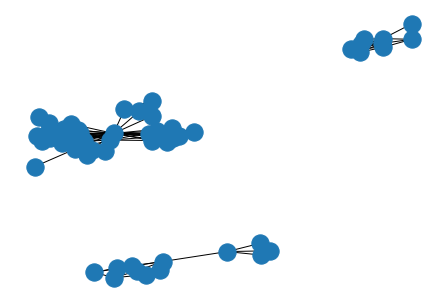

<Figure size 432x288 with 0 Axes>

In [8]:
import networkx as nx
from sklearn.decomposition import PCA
edges = set()
nodes = set()
for edge in open("data/egonet.txt", 'r'):
    x,y = edge.split()
    x,y = int(x),int(y)
    edges.add((x,y))
    edges.add((y,x))
    nodes.add(x)
    nodes.add(y)

G = nx.Graph()
for e in edges:
    G.add_edge(e[0],e[1])
nx.draw(G)
plt.show()
plt.clf()

In [9]:
print("Connected component:")

to_process = set(nodes)
processed = set()

clusters = []
while len(to_process) > 0:
    curr = set()
    curr.add(to_process.pop())
    added = True
    while len(set(curr - processed)) > 0 and len(to_process) > 0:               
        check = set(curr - processed)
        x = check.pop()  
        curr.add(x)
        processed.add(x)
        for e in edges:
            if e[0] == x:
                if e[1] in to_process:
                    to_process.remove(e[1])
                curr.add(e[1])
            if e[1] == x:
                if e[0] in to_process:
                    to_process.remove(e[0])
                curr.add(e[1])
    clusters.append(set(curr))
    
print("Number of connected components: {}".format(nx.number_connected_components(G)))
print("Number of nodes in the largest connected component: {}".format(max(len(c) for c in clusters)))

Connected component:
Number of connected components: 3
Number of nodes in the largest connected component: 40


In [10]:
print("Normalized-cut cost:")

def norm_cut_cost(t, b):
    top_degree = sum([G.degree(n) for n in t])
    bot_degree = sum([G.degree(n) for n in b])
    cut = 0
    for e in edges:
        if e[0] in t and e[1] in b:
            cut+=1
    cost = 1/2*(cut/top_degree + cut/bot_degree)
    
    return cost

largest_comp = list(clusters[0])
largest_comp.sort()
top = largest_comp[len(largest_comp)//2:]
bot = largest_comp[:len(largest_comp)//2]

print("Normalized Cut Cost: {}".format(norm_cut_cost(top, bot)))


Normalized-cut cost:
Normalized Cut Cost: 0.42240587695133147


In [11]:
top = set(top)
bot = set(bot)

minimised = False
while not minimised:
    minimised = True
    t = set(top)
    b = set(bot)
    cost = norm_cut_cost(list(top), list(bot))
    min_cost = cost
    for i in largest_comp:
        if i in t:
            t.remove(i)
            b.add(i)
        else:
            b.remove(i)
            t.add(i)
        c = norm_cut_cost(list(t), list(b))
        if c < min_cost:
            min_cost = c
            min_t = set(t)
            min_b = set(b)
            minimised = False
        t = set(top)
        b = set(bot)
    if not minimised:
        top = set(min_t)
        bot = set(min_b)

print("Top:\n", top)
print("\nBot:\n", bot)

print("Normalized Cut Cost: {}".format(norm_cut_cost(list(top), list(bot))))


Top:
 {864, 804, 876, 861, 878, 882, 884, 729, 886, 888, 825, 893, 889, 863}

Bot:
 {769, 772, 708, 774, 840, 713, 719, 856, 798, 800, 803, 805, 869, 745, 810, 811, 747, 880, 753, 819, 823, 697, 890, 828, 830, 703}
Normalized Cut Cost: 0.09817045961624274
